In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='47c9f612-6569-4152-9987-8bdba8d87f20', project_access_token='p-af3ca78a94543969b76262f753a73ac8dea3125b')
pc = project.project_context

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20210318150659-0001
KERNEL_ID = 035007b7-2288-42ab-9a1b-b3b8627b8bb3


# Tutorial: Using tspy for Timeseries Analysis

This notebook serves as a self-service tutorial for the data scientist in using [Watson Studio's tspy library](https://cloud.ibm.com/docs/AnalyticsEngine?topic=AnalyticsEngine-time-series), that provides timeseries analytic capabilities.

The Timeseries Toolkit comes fully integrated with Apache Spark and in doing so is capable of effectively scaling the analysis. It provides the ability to handle timeseries data of any data type (doubles, strings, geo-locations etc.), data that may be unaligned or non-periodic and as such can be used in a variety of applications. For example, you can easily store and analyze metric and log data for DevOps, sensor data for IoT applications, network traffic data, and industrial telemetry data for equipment maintenance. 

<a name="intro"></a>
This notebook describes a simple analytics pipeline, illustrating some of the common steps one might use in the analysis of timeseries data such as: 
1. [Basic Concepts](#concepts)
2. [Data Introduction](#data)
 *   [Temperature and Humidity](#stmt1)
 *   [Particulate matter](#stmt2)
3. [Data Cleanup and Alignment](#align)
4. [Computing Correlations](#corr)
5. [Segmentation](#segment)
6. [Forecasting](#forecast)

In [2]:
import numpy as np
import pandas as pd

In [7]:
import sparktspy as tspy

import tspy.functions as tsfunc

print(tspy.__version__)

2.0.5.0


## <a name="concepts"></a> 1. [Basic Concepts](#intro): 

There are different concepts introduced in `tspy` which you can reference [here](https://ibm-cloud.github.io/tspy-docs/intro.html#what-is-tspy). Here, we discuss two of them, that would be essential to creating timeseries (whether it be univariate or multiple univariate or multivariate).

### <a name="observations"></a> Observations
An `observation` is a combination of a time-stamp and a measurement. A series of observations collectively are `observations` (or an observation collection). 

NOTE: A [time-stamp](https://ibm-cloud.github.io/tspy-docs/intro.html#what-is-a-timestamp-in-tspy) here is a generic concept, and is represented as an integer, which can be mapped to a time-reference system if needed. A [TRS (Time reference system)](https://ibm-cloud.github.io/tspy-docs/tspy.data_structures.observations.TRS.html?highlight=trs#module-tspy.data_structures.observations.TRS) enables contextualization of a `timetick` to a `Calendar` and `timezone`. This enables easy manipulation of timestamps with context. However, we will focus on other aspects in this tutorial.

Details on observations can be found [here](https://ibm-cloud.github.io/tspy-docs/intro.html#what-is-an-observation-in-tspy).

### <a name="sts-mts"></a> Single-time series (STS), Multi-time series (MTS)

A (single-) time series (STS) is like a series of observations, ordered by timestamp. A multi-time series (MTS) is a data structure that wraps multiple single-time series, from which you can apply a function on each single-time series.

We can create a STS or MTS from 

    * In-memory list
    * Pandas Dataframe
    * In-memory collection of observations (ObservationCollection)
    * User defined reader (TimeSeriesReader)

You can refer to API docs for creating [STS](https://ibm-cloud.github.io/tspy-docs/tspy.time_series.html) and [MTS](https://ibm-cloud.github.io/tspy-docs/tspy.multi_time_series.html).

In [15]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns

sns.set(rc={'figure.figsize':(20, 6)})

## <a name="data"></a> 2. [Data Introduction](#intro)

We will use an open source dataset, the [OK Lab data](https://luftdaten.info/en/home-en/) that has been made available by the [Open Knowledge Foundation of Germany](http://okfn.de/).


The data consists of two types of sensors spread out across a wide region (primarily in Germany), one is a particulate sensor and the other is a temperature and humidity sensor. Particulate matter (PM) are of two types:

    PM10 inhalable particles, of diameter less than 10 micrometers
    PM2.5 inhalable particles, of diameter less than 2.5 micrometers

Particulate matter when inhaled can cause serious health conditions depending on the nature of the particles. A list of most polluted cities in the world through the measure of particulate matter concentration can be found [here](https://en.wikipedia.org/wiki/List_of_most-polluted_cities_by_particulate_matter_concentration).

In this particular installation, there are two types of sensors -- a temperature and humidity sensor (DHT) and a corresponding particulate matter (PM) count as described above. For a detailed introduction to the dataset used here, the user is referred to [this notebook](https://eu-gb.dataplatform.cloud.ibm.com/exchange/public/entry/view/5d686c16d14491f4c3997b67fe11506d). For the purpose of demonstrating timeseries functionality, we begin by preparing a dataset of a resonable duration i.e. lengths between 1000 and 2000 so that meaningful downstream analysis can be performed. 

We are using two data sets specifically:

-  **DHT (temperature and humidity): cos://us-geo/sql/oklabdata/parquet/dht22/**
-  **SDS (Particulate matter): cos://us-geo/sql/oklabdata/parquet/sds011/**

### Data ETL


We previously extracted data that contains 4 fields `location`, `temperature`, `humidity`, and `timestamp` for locations that have between 1000 and 2000 data points from both DHT (humidity and temperature) and PM (particulate matter) sensors.  The results are stored as csv files for the purpose of this notebook.

For particulate matter, we obtain 4 fields `location`, `P1`, `P2`, and `timestamp`.

NOTE: P1 and P2 columns contains P10, and P2.5 inhalable particle data, respectively.

In [16]:
# let's assume you have the pandas DataFrame  pandas_df which contains the data
# you want to save in your object storage as a csv file
my_file = project.get_file("location_T_humidity.csv")
my_file.seek(0)
df = pd.read_csv(my_file)
temp_humid = df
temp_humid.head(10)

,location,temperature,humidity,timestamp
0,1336,14.9,92.5,2017-09-30 04:00:26
1,1336,14.9,92.4,2017-09-30 04:02:52
2,1336,14.9,91.9,2017-09-30 04:05:19
3,1336,14.9,91.9,2017-09-30 04:07:46
4,1336,14.9,91.9,2017-09-30 04:10:13
5,1336,14.9,91.9,2017-09-30 04:12:39
6,1336,14.9,92.0,2017-09-30 04:15:06
7,1336,15.0,91.8,2017-09-30 04:17:33
8,1336,15.0,91.8,2017-09-30 04:19:59
9,1336,15.0,91.7,2017-09-30 04:22:26


In [17]:
# let's assume you have the pandas DataFrame  pandas_df which contains the data
# you want to save in your object storage as a csv file
my_file = project.get_file("location_P1_P2.csv")
my_file.seek(0)
df = pd.read_csv(my_file)
p1_p2 = df
p1_p2.head(10)

,location,P1,P2,timestamp
0,2975,23.63,18.80,2017-09-29 00:00:41
1,2975,24.17,20.53,2017-09-29 00:03:08
2,2975,21.70,17.73,2017-09-29 00:05:35
3,2975,30.00,18.93,2017-09-29 00:08:02
4,2975,21.30,17.77,2017-09-29 00:10:28
5,2975,22.07,18.10,2017-09-29 00:12:55
6,2975,25.77,20.03,2017-09-29 00:15:22
7,2975,19.73,17.53,2017-09-29 00:17:48
8,2975,18.80,15.70,2017-09-29 00:20:15
9,2975,21.23,15.57,2017-09-29 00:22:42


#### <a name="stmt1"></a> Create timeseries

We construct multi-timeseries for each location separately for DHT and Particulate sensors. We note that these timeseries are coming from two different devices and hence they are not of equal lengths nor are they aligned by timestamp. 

In [11]:
df1 = temp_humid
df1=df1.astype({'location':'int64'})

mts1 = tspy.multi_time_series(df1, key_column="location", ts_column="timestamp", value_column="temperature")
print((mts1.keys))
print("======")

['2976', '1336', '2975', '971', '2996', '630', '691', '2989']


#### <a name="stmt2"></a> Examine Temperature & Humidity Data Set

The first step in analysis is to simply examine the data and obtain some basic statistics. With multi-time series, we can access a single key or iterate through its keys and use `.describe()` to get basic stats on the timeseries. We show one example based on the keys from the previous cell.

The `describe` method provides basic stats on the timeseries, such as the min, max, percentiles for the values, the starting and ending timestamp, the number of unique values, inter-arrival times. This can be very useful starting point.

The APIs are described [here](https://ibm-cloud.github.io/tspy-docs/howto.html#collect-statistics).


In [18]:
desc = mts1['2976'].describe()
print(desc)

min inter-arrival-time: 139000
max inter-arrival-time: 305000
mean inter-arrival-time: 147073.25194228636
top: 14.3
unique: 145
frequency: 57
first: TimeStamp: 1506550864000     Value: 10.2
last: TimeStamp: 1506815890000     Value: 11.4
count: 1803
mean:15.284470327232391
std:4.085681419514389
min:8.8
max:24.0
25%:12.5
50%:14.1
75%:18.9



#### <a name="stmt3"></a> Prepare Particulate Matter Data Set

Next, we look at the other sensor --  Particulate Matter (PM). Exactly as we did with [DHT data](#stmt1), this time with timestamps and P1 as the inputs to create a multi-timeseries of PM values.


In [19]:
df2 = p1_p2
df2=df2.astype({'location':'int64'})

mts2 = tspy.multi_time_series(df2, key_column="location", ts_column="timestamp", value_column="P1")
print((mts2.keys))

['2976', '1336', '2975', '971', '2996', '630', '691', '2989']


In [20]:
desc = mts2['2976'].describe()
print(desc)

min inter-arrival-time: 138000
max inter-arrival-time: 305000
mean inter-arrival-time: 147073.25194228636
top: 34.0
unique: 1439
frequency: 4
first: TimeStamp: 1506550864000     Value: 83.97
last: TimeStamp: 1506815890000     Value: 2.27
count: 1803
mean:83.14671658347199
std:105.65445659939499
min:2.07
max:714.03
25%:30.1
50%:47.73
75%:80.1



## <a name="align"></a> 3. [Data Cleanup and Alignment](#intro)

The simplest cleanup task in this case is that of data alignment. We note that even though they are located at the same place, the PM and DHT sensors do not run on the same clock. This results in different timestamps for each of the sensors. Further, we note that the PM sensor is valid (according to the specification/data sheet) when humidity is <70%. 

### Data Alignment

Data alignment is normally a very complex process as it involves aligning two timeseries whose timestamps may not be matching, and subsequently interpolating missing values. However this fundamental step is necessary to perform any downstream operation (e.g., selecting valid data for further analysis, correlations etc.). The Timeseries Toolkit makes the alignment very simple by providing in-built transforms for all types of joins, key supported joins given two timeseries `ts1` and `ts2`:

* **Inner**: ts1.inner_join(ts2) will align on the intersection of timestamps.
* **Left**: ts1.left_join(ts2) will align on the timestamps of ts1, missing timestamps in ts2 are filled as per the interpolator provided
* **Right**: ts1.right_join(ts2) = ts2.left_join(ts1)
* **Left Outer**: ts1.left_outer_join(ts2) will keep all ts1 timestamps and align on intersecting timestamps and fill with interpolator for missing ones.
* **Right Outer**: ts1.right_outer_join(ts2) = ts2.left_outer_join(ts1)
* **Full**: ts1.full_join(ts2) = ts2.full_join(ts1) will union all the timestamps from ts1 and ts2 and fill with interpolator where values are missing

### Interpolators
When aligning timeseries, data can be usually missing. Missing data can be filled with `interpolators`. The library provides out of the box interpolators that can be used (or the user can write their own custom interpolators). Some of the provided interpolators are:

* **fill**: Fill with value provided
* **linear**: Linear interpolation using the history and future sizes
* **cubic**: Cubic spline interpolation using history and future sizes
* **nearest**: Fill with nearest value, if not available use the provided value

The full list of interpolators can be found [here](https://ibm-cloud.github.io/tspy-docs/tspy.functions.interpolators.html)

In [25]:
# Before the alignment, each time-series may have the same number of observations, yet the observation on each time-series may not all aligned to each other
print("Before alignment, DHT 2976 count: " + str(mts1['2976'].count()))
print("Before alignment, P1P2 2976 count: " + str(mts2['2976'].count()))

#Fill with nearest interpolator, if unavailable will be 0.0
mts1_aligned, mts2_aligned = mts1.full_align(mts2, tsfunc.interpolators.nearest(0.0), tsfunc.interpolators.nearest(0.0))

#An example of using a custom lambda for fill
# mts1_mts2_aligned = mts1_aligned.left_join(mts2_aligned, join_func=lambda temp,pm: tspy.record(**{"temp": temp, "pm": pm}))

# After the alignment, each may have the same number of observations, the observation on each time-series may not all aligned to each other
print("After alignment, DHT 2976 count: " + str(mts1_aligned['2976'].count()))
print("After alignment, P1P2 2976 count: " + str(mts2_aligned['2976'].count()))

Before alignment, DHT 2976 count: 1803
Before alignment, P1P2 2976 count: 1803
After alignment, DHT 2976 count: 2449
After alignment, P1P2 2976 count: 2449


### <a name="stmt7"></a> Convert back to DataFrame 
Since the timeseries is a complex datatype, we can convert it back to Pandas' DataFrame to consume it easily in subsequent queries (or for visualization). 


The APIs are discussed [here](https://ibm-cloud.github.io/tspy-docs/howto.html#convert-back-to-dataframe)

In [26]:
df1_aligned = mts1_aligned.to_df()
df2_aligned = mts2_aligned.to_df()

df1_aligned.head(10)

,timestamp,key,value
0,2017-09-27 22:21:04,2976,10.2
1,2017-09-27 22:23:31,2976,10.2
2,2017-09-27 22:23:32,2976,10.2
3,2017-09-27 22:25:59,2976,10.2
4,2017-09-27 22:28:25,2976,10.2
5,2017-09-27 22:28:26,2976,10.2
6,2017-09-27 22:30:52,2976,10.3
7,2017-09-27 22:33:18,2976,10.2
8,2017-09-27 22:33:19,2976,10.2
9,2017-09-27 22:35:46,2976,10.2


In [37]:
merged_inner = pd.merge(df1_aligned, df2_aligned, left_on=["key", "timestamp"], right_on=["key", "timestamp"])

merged_inner = merged_inner.rename(columns={"value_x": "temperature", "value_y": "P1"})
merged_inner.head(10)

,timestamp,key,temperature,P1
0,2017-09-27 22:21:04,2976,10.2,83.97
1,2017-09-27 22:23:31,2976,10.2,96.40
2,2017-09-27 22:23:32,2976,10.2,96.40
3,2017-09-27 22:25:59,2976,10.2,91.90
4,2017-09-27 22:28:25,2976,10.2,84.47
5,2017-09-27 22:28:26,2976,10.2,84.47
6,2017-09-27 22:30:52,2976,10.3,70.17
7,2017-09-27 22:33:18,2976,10.2,71.50
8,2017-09-27 22:33:19,2976,10.2,71.50
9,2017-09-27 22:35:46,2976,10.2,59.90


### Plot the aligned timeseries
Now that we have the timeseries merged, we can plot a few examples to see how the align process helped fill the missing values and handle different length timeseries.

In [28]:
import matplotlib.pyplot as plt

%matplotlib inline

def plot_multi(data, cols=None, spacing=.1, **kwargs):

    from pandas import plotting

    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
    try:
        colors = getattr(getattr(plotting, '_matplotlib').style, '_get_standard_colors')(num_colors=len(cols))
        #colors = plotting._style._get_standard_colors(num_colors=len(cols))
    except:
        import matplotlib.pyplot as plt
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)], **kwargs)
        ax_new.set_ylabel(ylabel=cols[n])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax
    

location: 2976


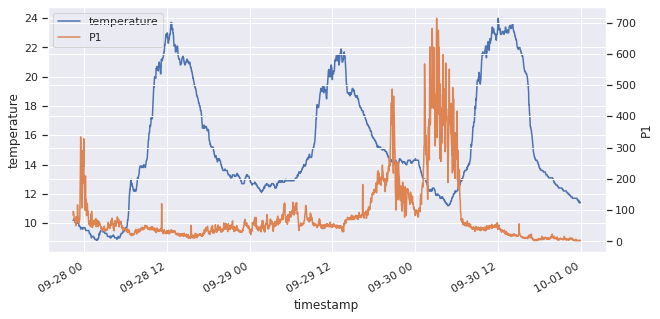

location: 1336


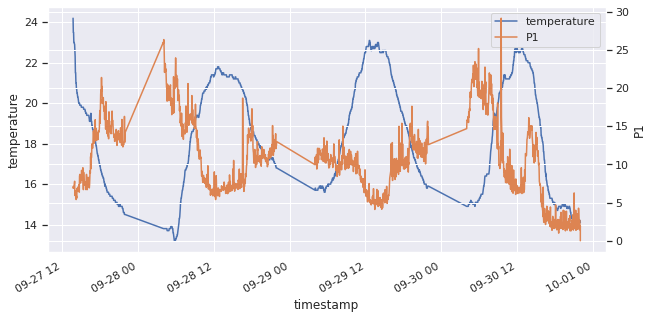

location: 2975


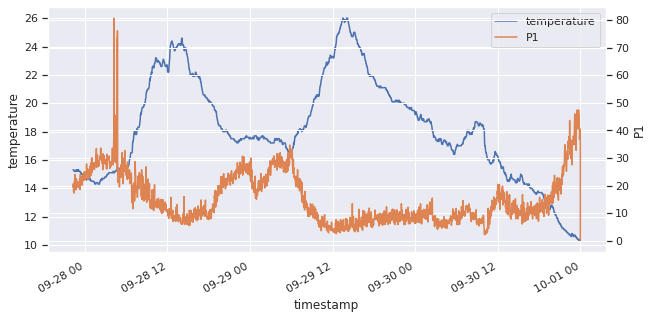

In [38]:
# keys = merged_inner.key.unique()
# For ease of plotting, we only show 3 timeseries aligned
keys = [2976, 1336, 2975]
for key in keys:
    print("location: {}".format(key))
    ts = merged_inner[merged_inner.key == key].copy()
    ts.set_index('timestamp', inplace=True)
    plot_multi(ts[["temperature", "P1"]], figsize=(10, 5))
    plt.show()

## <a name="corr"></a> 4. [Computing Correlations](#intro)

A simple analysis that we can do is to compute correlations between two timeseries. In this case, the out of the box correlation is [Pearson Correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient).


A full list of correlations functions that are supported are provided [here](https://ibm-cloud.github.io/tspy-docs/howto.html#correlate-two-time-series)

#### <a name="stmt10"></a>Computing Correlations on Timeseries Data


In [42]:
from tspy.functions import reducers

corrs = {}
corrs['location'] = []
corrs['corr'] = []
for k in mts1_aligned.keys:
    correlation_k = mts1_aligned[k].reduce(mts2_aligned[k], reducers.correlation())
    corrs['location'].append(k)
    corrs['corr'].append(correlation_k)
df = pd.DataFrame().from_dict(corrs)

display(df)

,location,corr
0,2976,-0.270134
1,1336,-0.365038
2,2975,-0.590580
3,971,0.096406
4,2996,-0.187111
5,630,-0.562988
6,691,-0.317470
7,2989,-0.612918


Text(0.5, 1.0, 'Correlation between humidity and particulate matter for each location')

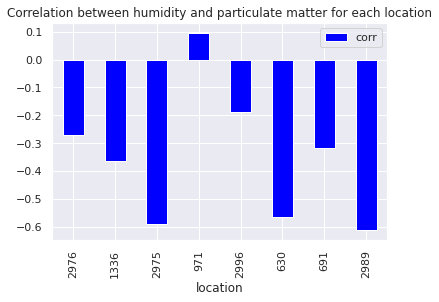

In [43]:
ax = df.plot(kind='bar', x='location', color='blue')
ax.set_title("Correlation between humidity and particulate matter for each location")

In general, we observe that as the temperature is going lower in most locations, the particulate matter (P1) is going higher, i.e. there is a negative correlation between temperature and particulate matter.

##  <a name="segment"></a> 5. [Segmentation](#intro)

Often times, we need to look at segments of the timeseries instead of the entire series. For example, we might want to look at hourly aggregates and understand how temperatures are changing in a day. We will show how one can segment based on a time window, wherein the number of records in each time segment could be varying. In certain cases, we may be interested in a paritcular event (TEMP > 70) which forms our "anchor" and we may want to provide a left and right window around the anchor to examine a segment of interest. We also provide the ability to simply segment by a fixed number of records.


In this example, we create hourly segments followed by an `average` over each segment of the TimeSeries. We show how we to use the linear interpolator to fill in missing values into the resulting series.

The APIs are discussed [here](https://ibm-cloud.github.io/tspy-docs/intro.html#segment-label).

In [50]:
# on particle data
from tspy.functions import reducers

segment_window_len = 60 * 60 * 1000 #timestamps are in ms
mts1_aligned_segment_avg = mts1_aligned.segment_by_time(segment_window_len, segment_window_len).transform(reducers.average())

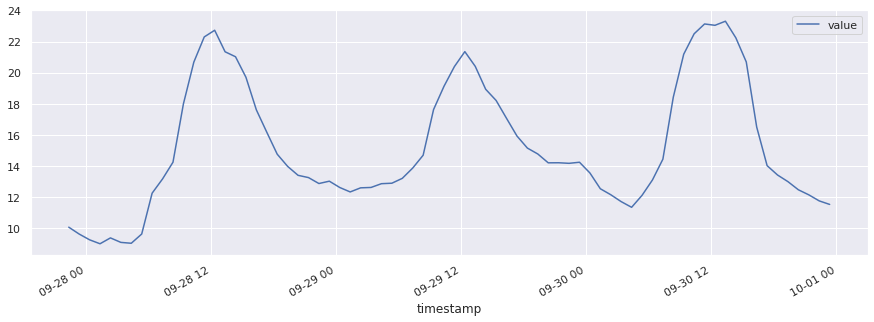

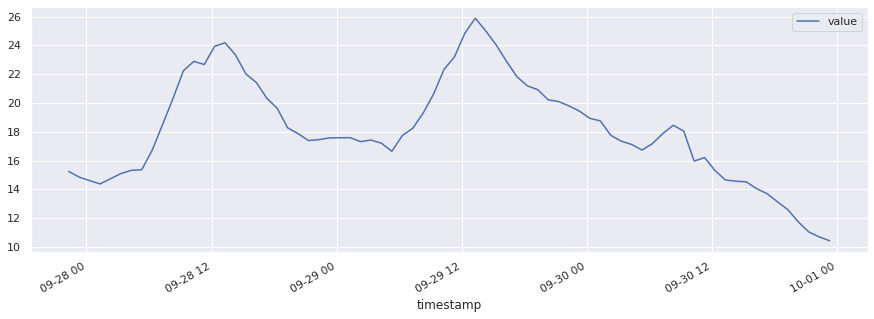

In [52]:
df = mts1_aligned_segment_avg.to_df_observations()
keys = [2976, 2975]
for key in keys:
    ts = df[df.key == key]
    ts.set_index('timestamp', inplace=True)
    ts[["value"]].plot(figsize=(15,5))
    plt.show()

## <a name="forecast"></a>  6. [Forecasting](#intro)

Finally, we look at a very common timseries problem -- forecasting. Our library provides various statistical forecasting algorithms out of the box. Currently, we support:

* Average
* Linear
* [ARMA](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model)
* [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)
* [Holt-Winters](https://en.wikipedia.org/wiki/Exponential_smoothing)
* [BATS](https://www.tandfonline.com/doi/abs/10.1198/jasa.2011.tm09771)
* Auto-forecaster: Picks the best forecaster among the options available


Detailed APIs are discussed [here](https://ibm-cloud.github.io/tspy-docs/howto.html#how-to-forecasting)


In [53]:
#Predict on temperature using hourly windows and train BATS with 1 day seasonality
mts1_aligned_segment_avg = mts1_aligned.segment_by_time(segment_window_len, segment_window_len).transform(reducers.average())

confidence = .99
#next two hours temperature predicted
num_predictions=2

#Build a BATS forecaster model with 50 records as training period, 2 * 24 at least to capture one day seasonality
model = tspy.forecasters.bats(50)

predictions = mts1_aligned_segment_avg.forecast(num_predictions, model, confidence=confidence)

In [71]:
# We can examine the predicted values for a given location
location='2976'
last_value = mts1_aligned_segment_avg[location].collect().last().value

In [73]:
#Predicted values
next_hour_temp = predictions[location].first().value['value']
two_hour_temp = predictions[location].last().value['value']

In [74]:
print('Location ' + location + ', current temperature = ' + str(last_value) + ', next hour predicted temp = ' + str(next_hour_temp) + ', two hour predicted temp = ' + str(two_hour_temp))

Location 2976, current temperature = 11.538095238095238, next hour predicted temp = 11.266317032024856, two hour predicted temp = 11.00184325204576


## [Conclusion](#intro)
Happy forecasting and cleaning timeseries data! This feature of Watson Studio shows how easy it is for any data scientist to start working with timeseries data, being able to create timeseries from pandas dataframes, clean them up, especially aligning and filling missing values, followed by manipulating segments and finally creating complex forecasting models taking seasonality into account. These are but the basic functionalities provided by the added timeseries functionality of Watson Studio.